# Cell Segmentation using:
1) Multi-layered Preceptron (MLP)
2) Convolutional Neural Networks (CNNs)

# Authors: 
    - Starter(Data Setup)/Helper Code provided by Dr. John Femiani
    - Modified by : Siddhant S. Karki (Sid)


# Starter Code / Functions

In [6]:
BASE_PATH="/home/sid/Drive_D/COLLEGE_MATERIALS/SOPHOMORE_2/CSE488/Cell-Tracking-Segmentation"

# Utility functions/imports are same as the traditional ML notebook

In [13]:
import os
import glob
from skimage import io
from sklearn.neural_network import MLPClassifier
from skimage.morphology import dilation, disk, opening, closing, erosion
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment
import pandas as pd
from skimage.exposure import equalize_hist
from skimage.util import view_as_windows
from tqdm import trange
from tqdm import tqdm
import pickle

In [4]:
def compute_jaccard_index_for_matches(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask = label(seg_mask)
    # Extract properties of labeled regions
    mask_props = regionprops(labeled_mask)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in np.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize an array to hold overlaps with mask objects
        overlaps = []

        for prop in mask_props:
            # Calculate intersection and union with each segmented object
            intersection = np.sum(ref_object & (labeled_mask == prop.label))
            union = np.sum(ref_object | (labeled_mask == prop.label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * np.sum(ref_object):
                jaccard_index = intersection / union
                overlaps.append(jaccard_index)
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[ref_label] =best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = np.mean(list(jaccard_indices.values())) if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices
    
def getImgFeatures(image_dir, window_size):
    image = io.imread(image_dir)
    image = (image-np.mean(image)) / np.std(image)
    image = equalize_hist(image)
    # add any sort of preprocessing in the flat features
    height, width = image.shape
    image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
    flat_features = image_features.reshape(height*width, window_size**2)
    return flat_features, image.shape

def getTarget(target_dir):
    target_image = io.imread(target_dir)
    targets = target_image.flatten() > 0
    num_fg = np.sum(targets)
    num_bg = len(targets) - num_fg
    weights = np.where(targets==0, num_fg, num_bg)
    return targets, weights

def getTrainingMatrix(image_folders, mask_folders, sample_size=100, dataset_size=None, window_size=10):
    final_df = pd.DataFrame()
    img_shape = 0
    for i in trange(len(image_folders)):
        img_folder = image_folders[i]
        mask_folder = mask_folders[i]
        img_names = sorted(glob.glob(os.path.join(img_folder, "*.tif")))
        mask_names = sorted(glob.glob(os.path.join(mask_folder, "SEG", "*.tif")))
        if not dataset_size:
            dataset_size = len(img_names)
        for j in range(dataset_size):
            _image_dir = img_names[j]
            _msk_dir = mask_names[j]
            flat_features, img_shape = getImgFeatures(_image_dir, window_size)
            targets, weights = getTarget(_msk_dir)
            temp_df = pd.DataFrame(flat_features)
            temp_df['target'] = targets
            # sample from the retrived dataframe
            sample_df = temp_df.sample(sample_size, weights=weights)
            if len(final_df) == 0:
                final_df = sample_df
            else:
                final_df = pd.concat([final_df, sample_df])
    return final_df, img_shape
    
def create_test_inferences(model, model_name, resize_shape=(256,256), window_size=5, postprocess=False):
    pdir_name = os.path.join(BASE_PATH, "test-datasets", "Fluo-N2DH-GOWT1")
    tracks = glob.glob(os.path.join(pdir_name, "", "0[0-9]"))
    # print(tracks)
    with tqdm(total=len(tracks)) as pbar:
        for track_number in tracks:
            # print(track_number)
            dir_name = os.path.join(pdir_name, f"{track_number}_{model_name}", "")
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            test_img_names = glob.glob(os.path.join(pdir_name, track_number, "*.tif"))
            
            # pbar.write(f"Working on {model_name} -- {track_number[-2:]}")
            for test_img_name in test_img_names:
                # print(test_img_name)
                test_img_path = os.path.join(pdir_name, track_number, test_img_name)
                test_img = io.imread(test_img_path)
                test_img_features, shape = getImgFeatures(test_img_path, window_size=window_size)
                predicted = model.predict(test_img_features).reshape(shape).astype(np.uint8)
                if postprocess:
                    if track_number == '01':
                        predicted = process01(predicted)
                    else:
                        predicted = process02(predicted)
                saving_path = os.path.join(dir_name, f"mask{test_img_name[-7:-4]}.tif")
                io.imsave(saving_path, predicted, check_contrast=False)
            pbar.update(1)
            
def process01(predictions):
    eroded = erosion(predictions, disk(3))
    return eroded
def process02(predictions):
    eroded = erosion(predictions, disk(1))
    dialated = dilation(eroded, disk(1))
    return dialated
# Load pickled data from file
def save_model(model, model_name):
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

def display_all_viz(images, track, model):
    for image in images:
        displayResults(model, image, track)

def displayResults(model, img_num, track):
    img = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}/t{img_num}.tif")
    ground_truth = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_GT/SEG/man_seg{img_num}.tif") > 0
    predicted = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_{model}/mask{img_num}.tif")
    # predicted = dilation(predicted, disk(5))
    names = {
        'N_BAYES' : "Naive Bayes",
        'SVC_L' : "Support Vector Machine (Linear)",
        'SVC_R' : "Support Vector Machine (RBF)",
        'LOG' : "Logistic Regression",
        'MLP' : "Net(v1)",
        'CNN' : "CNN"
    }
    fig, ax = plt.subplots(1,3, figsize=[20,15])
    ax[0].imshow(img, cmap='gray')
    ax[0].axis("off")
    ax[0].set(title=f"Cell Image (Track_{track} : {img_num})")
    ax[1].imshow(ground_truth, cmap='gray')
    ax[1].axis('off')
    ax[1].set(title='Ground Truth (Silver Truth)')
    ax[2].imshow(predicted, cmap='gray')
    ax[2].axis('off')
    ax[2].set(title=f'Predicted ({names[model]})');

In [98]:
training_folder = os.path.join(f"{BASE_PATH}", "training-datasets", "Fluo-N2DH-GOWT1")
image_folders = glob.glob(os.path.join(training_folder, "0[0-9]"))
mask_folders = glob.glob(os.path.join(training_folder, "0[0-9]_ST"))

training_df, img_shape = getTrainingMatrix(image_folders, mask_folders, sample_size=100, window_size=5, dataset_size=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.43s/it]


In [99]:
data = training_df

In [100]:
X, y = data.values[:,:-1], data.values[:,-1].astype(int)

In [101]:
X.shape

(17800, 25)

# Fitting MLP classifier

In [102]:
hidden_layer_sizes=(100, 50, 25)
activation='relu'

mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                           activation=activation,
                           max_iter=1000, random_state=42)
mlp.fit(X, y)


MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42)

# MLP Visual Evaluation

In [7]:
img_num = ["000", "052", "077"]

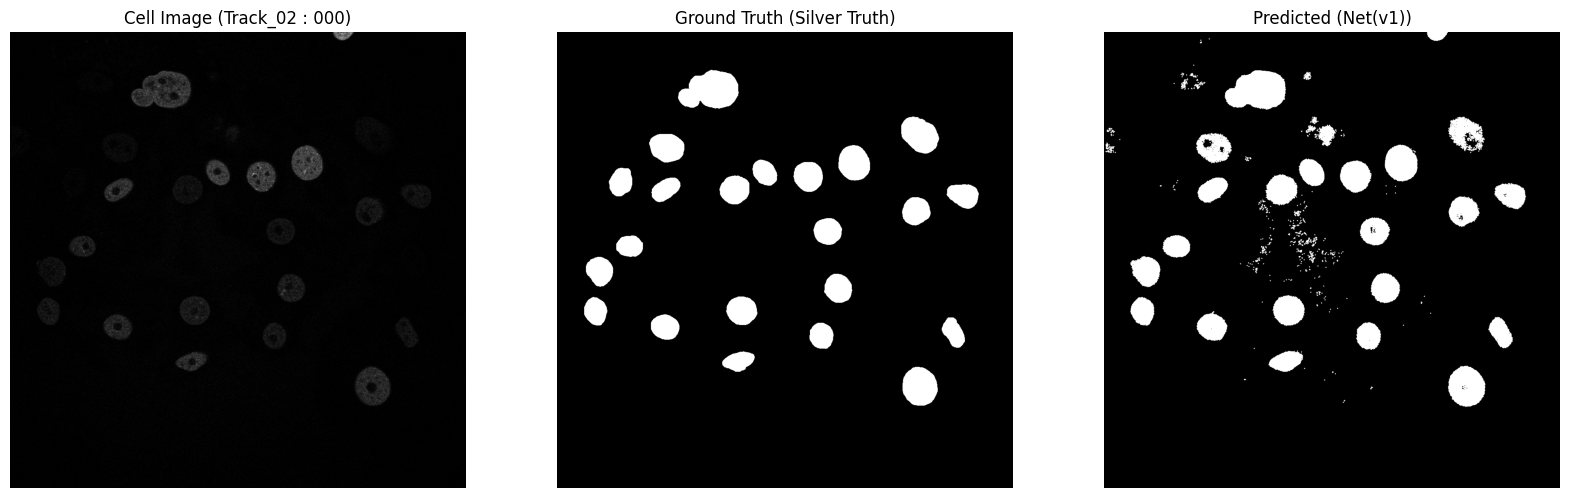

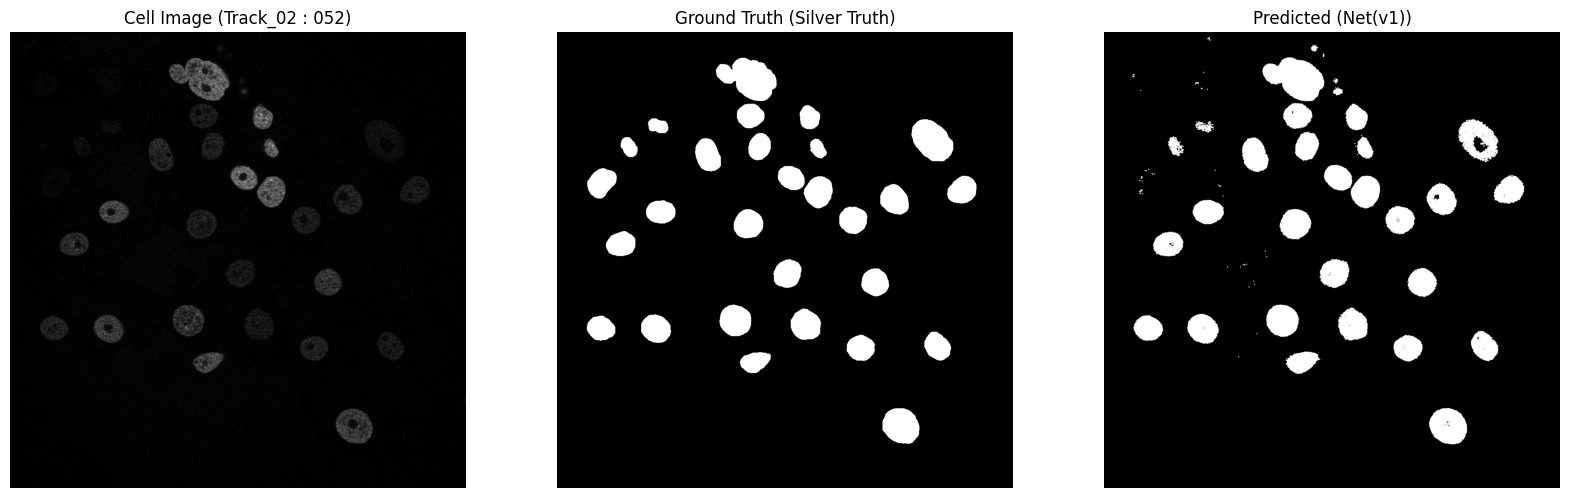

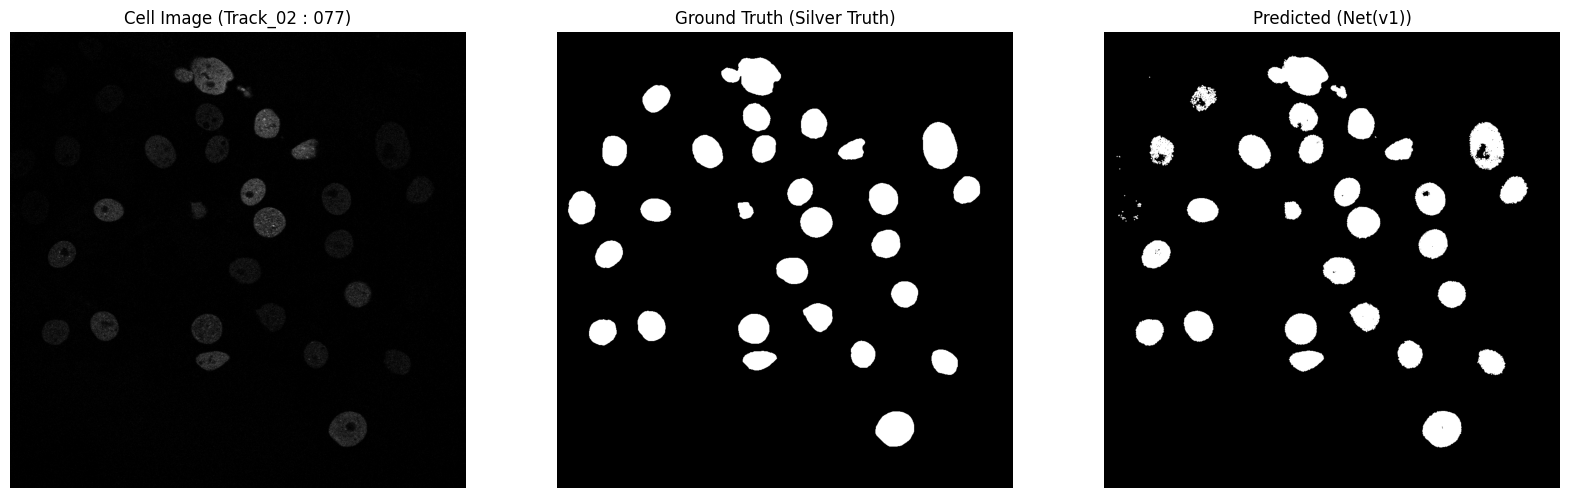

In [15]:
display_all_viz(img_num, "02", "MLP")

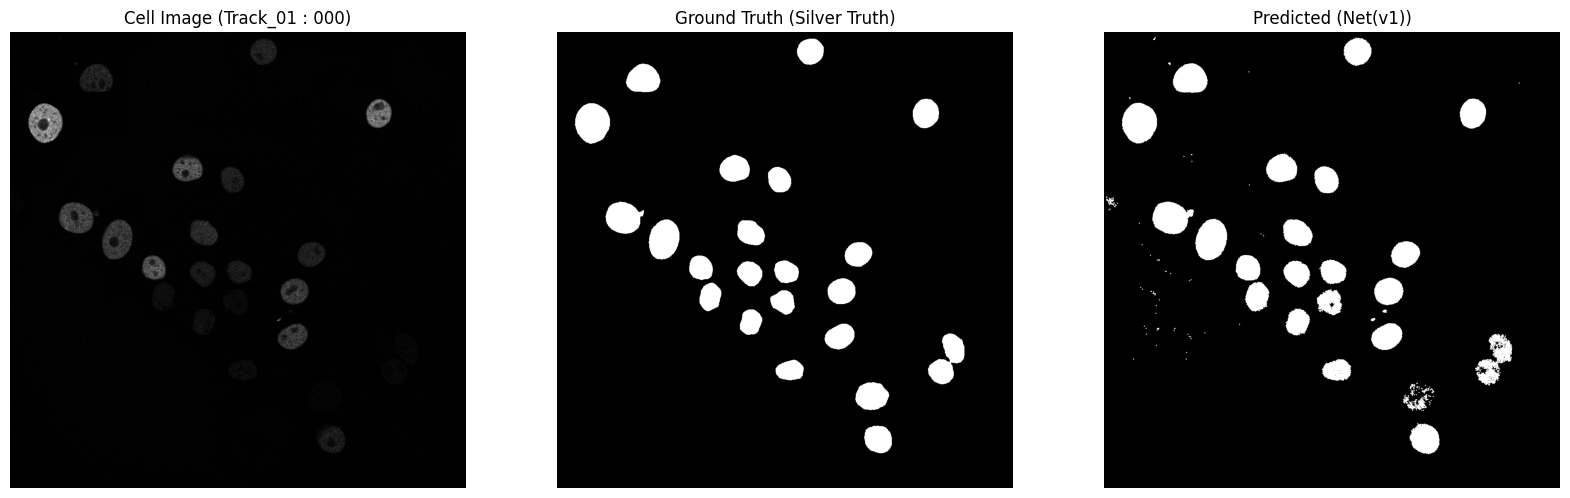

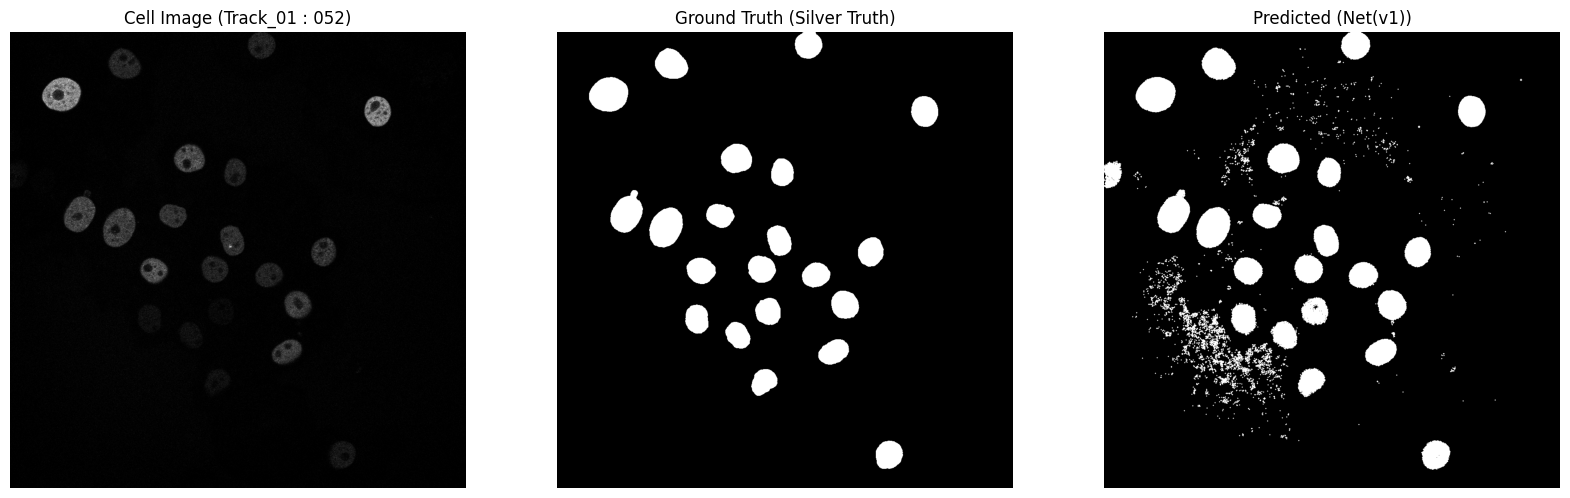

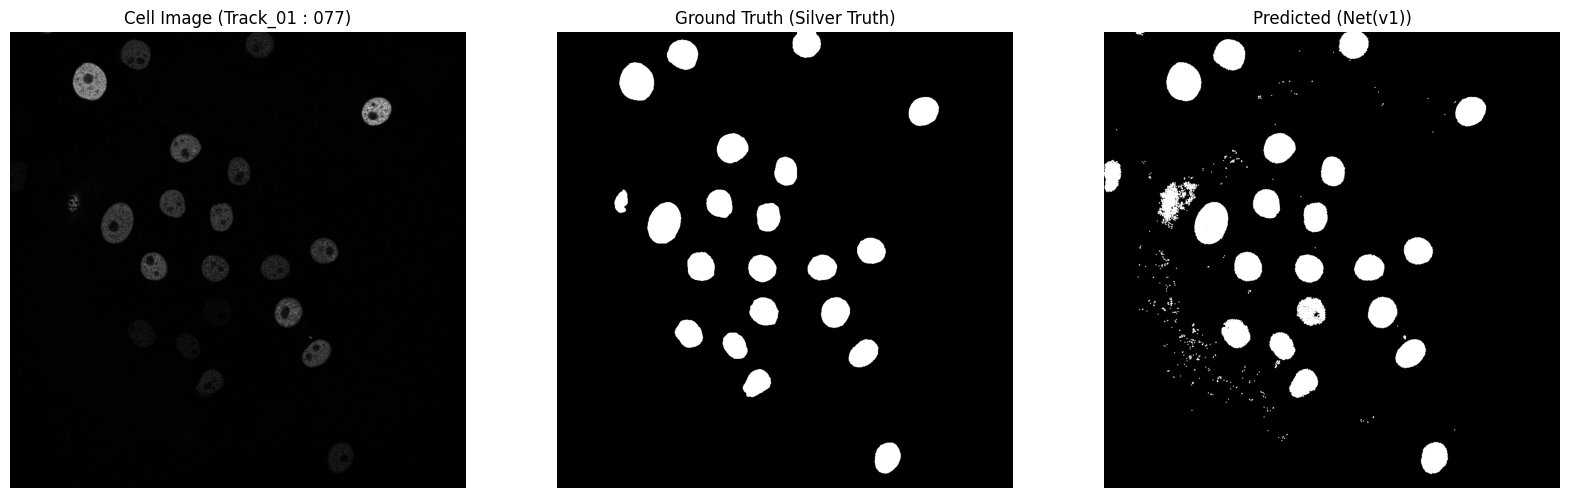

In [16]:
display_all_viz(img_num, "01", "MLP")

# ---------------------------------------------------------------------------------------------

# Convolutional Neural Network Segmentation

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from PIL import Image

# Dataset Class

In [76]:
class CellDataset(Dataset):
    def __init__(self, dataset_dir, transforms=None, val=False):
        super(CellDataset, self).__init__()
        self.base_dir = dataset_dir
        self.transforms = transforms
        self.tracks = glob.glob(os.path.join(self.base_dir, "0[0-9]"))
        self.datadirs = []
        self.targetdirs = []
        for track in self.tracks:
            self.datadirs += sorted(glob.glob(os.path.join(track, "*.tif")))
            if not val:
                self.targetdirs += sorted(glob.glob(os.path.join(f"{track}_ST", "SEG", "*.tif")))
            else:
                self.targetdirs += sorted(glob.glob(os.path.join(f"{track}_GT", "SEG", "*.tif")))
    def __getitem__(self, i):
        image = Image.open(self.datadirs[i])
        # img = Image.open(img_path)
        target = Image.open(self.targetdirs[i])
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target.long()
    def __len__(self):
        return len(self.datadirs)


In [77]:
def get_transform():
    def transform(img, mask):
        img = F.resize(img, (512, 512))
        mask = F.resize(mask, (512, 512), interpolation=Image.NEAREST)
        img, mask =  F.to_tensor(img), F.to_tensor(mask).int().squeeze(0)
        return img, mask > 0.0 
    return transform

# Instantiate the dataset
dataset = CellDataset(dataset_dir='./training-datasets/Fluo-N2DH-GOWT1/', transforms=get_transform())

In [78]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [80]:
from torchvision.models.segmentation import FCN_ResNet101_Weights, fcn_resnet101
model = fcn_resnet101(weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)

In [81]:
def modify_model_for_single_class(model):
    # Change the last convolutional layer
    model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.classifier[-1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))  # Output 2 channels for 2 classes
    return model
torch.cuda.empty_cache()
model = modify_model_for_single_class(model)
model.to(device);

model.classifier[-1]

Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

In [82]:
from torch import nn, optim
from torch.nn import CrossEntropyLoss

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()  # We still use CrossEntropy, but now with 2 output channels

# Training loop
for epoch in range(15):
    running_loss = 0.0
    for images, masks in data_loader:
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(data_loader)}')

print('Finished Training')

Epoch 1, Loss: 0.14901072519381395
Epoch 2, Loss: 0.04440173691954841
Epoch 3, Loss: 0.026026120011726123
Epoch 4, Loss: 0.01868468942643886
Epoch 5, Loss: 0.01480357287179553
Epoch 6, Loss: 0.012433670005980836
Epoch 7, Loss: 0.011157761966244559
Epoch 8, Loss: 0.009773048548697589
Epoch 9, Loss: 0.008840521886484341
Epoch 10, Loss: 0.008157890193227135
Epoch 11, Loss: 0.007631022891218073
Epoch 12, Loss: 0.010565028138709872
Epoch 13, Loss: 0.008277419983315167
Epoch 14, Loss: 0.007098506730614921
Epoch 15, Loss: 0.0063861309801845735
Finished Training


In [83]:
model_path = 'fcn_cell_seg.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to fcn_cell_seg.pth


# CNN output masks visualizations

In [121]:
val_dataset = CellDataset(dataset_dir="./test-datasets/Fluo-N2DH-GOWT1/", val=True, transforms=get_transform())
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
# Function to visualize model predictions
def visualize_predictions(dl, model):
    model.eval()
    with torch.no_grad():
        for images, masks in dl:
            images = images.to(device)
            outputs = model(images)['out']
            _, predicted_masks = torch.max(outputs, 1)

    fig, axs = plt.subplots(nrows=len(images), ncols=3, figsize=(15, len(images) * 5))
    if len(images) == 1:
        axs = [axs]

    for i, (img, true_mask, pred_mask) in enumerate(zip(images, masks, predicted_masks)):
        axs[i][0].imshow(img.cpu().permute(1, 2, 0))
        axs[i][0].set_title("Image")
        axs[i][0].axis("off")

        axs[i][1].imshow(true_mask.cpu().squeeze(), cmap="gray")
        axs[i][1].set_title("True Mask")
        axs[i][1].axis("off")

        axs[i][2].imshow(pred_mask.cpu().squeeze(), cmap="gray")
        axs[i][2].set_title("Predicted Mask by Model")
        axs[i][2].axis("off")

    plt.show()

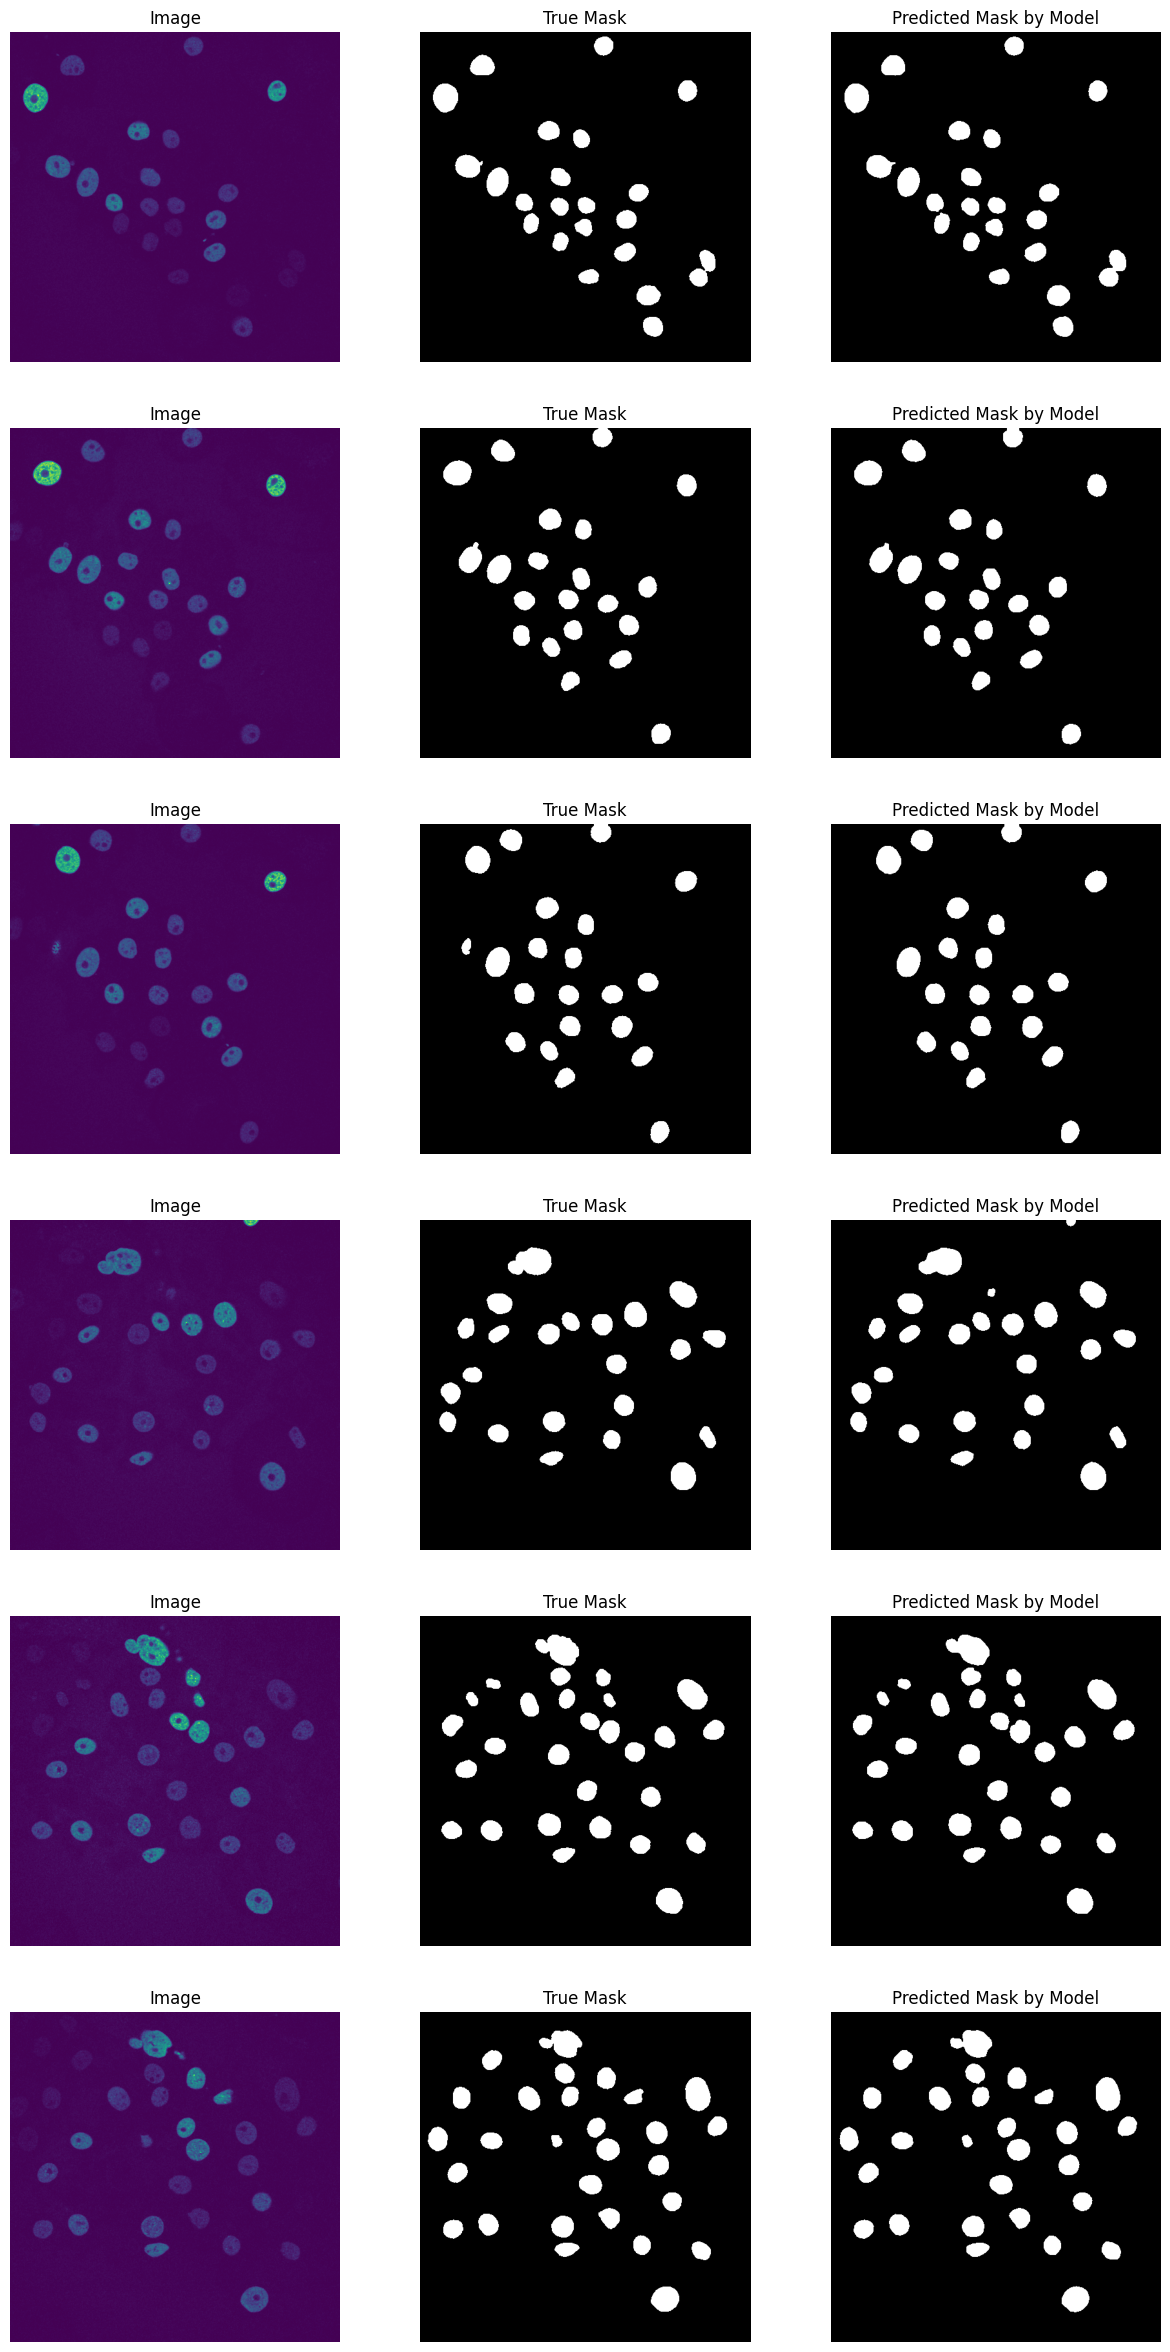

In [95]:
visualize_predictions(val_dataloader, model)

# Results

# MLP MIoU Evaluation

In [2]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/02_MLP

Mean Jaccard Index: 0.8644388634355732


In [17]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/01_MLP/

Mean Jaccard Index: 0.890376916331077


# CNN MIoU Evaluation

In [125]:
# Evaluate the model
import torch
import torch

def compute_jaccard_index_for_matches_tensor(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask, num_labels = torch.unique(seg_mask, return_counts=True)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in torch.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize a list to hold overlaps with mask objects
        overlaps = []

        for label in labeled_mask:
            # Calculate intersection and union with each segmented object
            intersection = torch.sum(ref_object & (seg_mask == label))
            union = torch.sum(ref_object | (seg_mask == label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * torch.sum(ref_object):
                jaccard_index = intersection.float() / union.float()
                overlaps.append(jaccard_index.item())
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[int(ref_label.item())] = best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = torch.tensor(list(jaccard_indices.values())).float().mean().item() if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices

    
def evaluate_model(model, data_loader):
    model.eval()
    jaccards = [] # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation to save memory and computations
        i = 0
        for images, true_masks in data_loader:
            if i == 2:
                accuracy = np.sum(jaccards) / len(jaccards)
                print(f"Model jaccard index on TRACK_01 validation set: {accuracy:.2f}")
                jaccards = []
            images = images.to(device)
            true_masks = true_masks.to(device)
            outputs = model(images)['out']
            _, predicted_masks = torch.max(outputs, 1)  # Get the predicted class (highest score)
            jacc = compute_jaccard_index_for_matches_tensor(true_masks, predicted_masks) # Count correct predictions
            jaccards.append(jacc[0])  # Total number of elements in the target mas
            i+=1
    accuracy = np.sum(jaccards) / len(jaccards)
    print(f"Model jaccard index on TRACK_02 validation set: {accuracy:.2f}")

# Call evaluate_model
evaluate_model(model, val_dataloader)

Model jaccard index on TRACK_01 validation set: 0.96
Model jaccard index on TRACK_02 validation set: 0.95


# Result Table

In [127]:
import pandas as pd
import numpy as np

# Define methods as columns -- customize if you add more
methods = ['Net (v1)', 'CNN']

# Define the variations heirarchically -- customize if you want to
# add other variations or other datasets from the contest site
datasets = {
    'Fluo-N2DH-GOWT1': {
        'ST': {'01', '02'}
    }
}

# Creating MultiIndex for rows
rows = []
for dataset, subsets in datasets.items():
    for subset, tracks in subsets.items():
        for track in tracks:
            rows.append((dataset, subset, track))

# Creating the DataFrame
multi_index = pd.MultiIndex.from_tuples(rows, names=['Dataset', 'Truth', 'Track'])
df = pd.DataFrame(index=multi_index, columns=methods).astype(float)

In [128]:
# Set the mIoU score for an experiment
df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'Net (v1)'] = 0.89 # Whatever you get
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'Net (v1)'] = 0.86 
df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'CNN'] = 0.96 # Whatever you get
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'CNN'] = 0.95
# Display the updated DataFrame
display(df)

Net (v1)   CNN
Dataset         Truth Track                
Fluo-N2DH-GOWT1 ST    01         0.89  0.96
                      02         0.86  0.95